In [5]:
from ultralytics import YOLO
detector = YOLO("./license_plate_detector.pt")



In [22]:
import cv2, numpy as np, easyocr, matplotlib.pyplot as plt
from ultralytics import YOLO
from pathlib import Path
from typing import Tuple, Optional

_detector = None   # cache global
_ocr      = None

def detect_plate_and_ocr(
    img_path: str | Path,
    yolo_weights: str | Path = "license_plate_detector.pt",
    conf: float = 0.3,
    size: tuple[int, int] = (50, 40),       # (width, height) destino
    show: bool = False,
) -> Tuple[Optional[np.ndarray], Optional[np.ndarray], Optional[str]]:
    """
    Detecta la placa, extrae texto OCR y devuelve:
      plate_bw : ndarray uint8 (40, 50) con valores 0/255.
      bits     : ndarray uint8 (2000,) con 0/1.
      text     : string con la matrícula (o None si falla).
    """
    global _detector, _ocr
    img_path = Path(img_path)
    if not img_path.exists():
        raise FileNotFoundError(img_path)

    # ── cargar modelos (lazy) ──────────────────────────────────────────
    if _detector is None:
        _detector = YOLO(str(yolo_weights))
    if _ocr is None:
        _ocr = easyocr.Reader(["en"], gpu=False)

    # ── leer imagen ───────────────────────────────────────────────────
    img = cv2.imread(str(img_path))
    if img is None:
        raise RuntimeError(f"OpenCV no pudo leer {img_path}")

    # ── detectar placa ────────────────────────────────────────────────
    results = _detector(img, conf=conf)[0]
    if len(results.boxes) == 0:
        print("⚠️  No se detectó ninguna placa.")
        return None, None, None

    i = results.boxes.conf.argmax()
    x1, y1, x2, y2 = map(int, results.boxes.xyxy[i])
    plate_crop = img[y1:y2, x1:x2]

    # ── OCR ────────────────────────────────────────────────────────────
    ocr_out = _ocr.readtext(plate_crop, detail=0, paragraph=False)
    text = ocr_out[0].strip() if ocr_out else None

    # ── binarizar + escalar ───────────────────────────────────────────
    w, h = size
    plate_gray = cv2.cvtColor(plate_crop, cv2.COLOR_BGR2GRAY)
    plate_resz = cv2.resize(plate_gray, (w, h), interpolation=cv2.INTER_AREA)
    # umbral adaptativo (robusto a iluminación)
    plate_bw   = cv2.adaptiveThreshold(
        plate_resz, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,
        35, 10
    )
    bits = (plate_bw == 255).astype(np.uint8).flatten()  # 0/1

    # ── visualización opcional ────────────────────────────────────────
    if show:
        img_rgb  = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        fig, ax  = plt.subplots(1, 2, figsize=(10, 4))
        ax[0].imshow(img_rgb)
        ax[0].add_patch(
            plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                          edgecolor="lime", linewidth=2, fill=False)
        )
        ax[0].set_title("Imagen con placa detectada")
        ax[0].axis("off")

        ax[1].imshow(plate_bw, cmap="gray")
        ax[1].set_title(f"Placa binaria 50×40\nOCR: {text}")
        ax[1].axis("off")
        plt.show()

    return plate_bw, bits, text





0: 640x480 1 license_plate, 127.0ms
Speed: 3.7ms preprocess, 127.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


/home/jpalaciosch/Documents/UNAL/Septimo semestre/Comunicaciones/Proyecto final/venv/lib64/python3.13/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


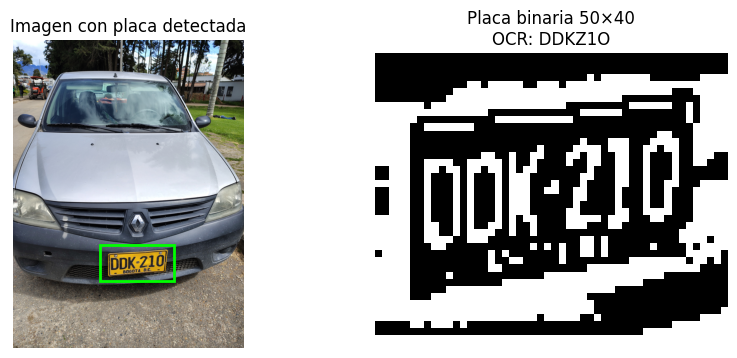

Texto detectado: DDKZ1O


In [26]:
plate, bits, txt = detect_plate_and_ocr(
        "dataset/autos/auto140.jpeg",
        yolo_weights="license_plate_detector.pt",
        conf=0.25,
        show=True
    )

if plate is not None:
    print("Texto detectado:", txt)





In [28]:
import pandas as pd, numpy as np, cv2, glob, os
from pathlib import Path

# ------------------------------------------------------------------
# 1. ajusta rutas y pesos
# ------------------------------------------------------------------
IMG_DIR   = Path("dataset/autos")                  # donde están auto###.jpeg
YOLO_PT   = "license_plate_detector.pt"            # pesos YOLO
OUT_ROOT  = Path("dataset_yolo")                   # destino del nuevo dataset
OUT_IMG   = OUT_ROOT / "autos_bw"                  # placas binarias
CSV_PATH  = OUT_ROOT / "dataset_yolo.csv"

OUT_IMG.mkdir(parents=True, exist_ok=True)

# ------------------------------------------------------------------
# 2. procesar todas las fotos -------------------------------------------------
# ------------------------------------------------------------------
records = []

files = sorted(glob.glob(str(IMG_DIR / "auto*.jp*g")))   # .jpg / .jpeg
for idx, fpath in enumerate(files, start=1):
    plate_bw, bits, text = detect_plate_and_ocr(
        fpath,
        yolo_weights=YOLO_PT,
        conf=0.25,
        show=False
    )

    if plate_bw is None:
        print(f"[{idx:03d}] sin placa → omitido")
        continue

    # ruta de salida para la placa binaria
    stem = Path(fpath).stem           # auto001
    out_name = f"{stem}.png"
    out_path = OUT_IMG / out_name

    cv2.imwrite(str(out_path), plate_bw)

    records.append({
        "num_auto": idx,
        "bw_plate": str(out_path),
        "bits": bits.tolist(),  # convertir a lista para JSON
        "ocr_txt" : text
    })
    print(f"[{idx:03d}] guardado  OCR='{text}'")

# ------------------------------------------------------------------
# 3. guardar CSV
# ------------------------------------------------------------------
df = pd.DataFrame(records)
CSV_PATH.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(CSV_PATH, index=False)
print("\n✅ Dataset generado:", CSV_PATH)



0: 640x512 1 license_plate, 147.3ms
Speed: 6.2ms preprocess, 147.3ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 512)


/home/jpalaciosch/Documents/UNAL/Septimo semestre/Comunicaciones/Proyecto final/venv/lib64/python3.13/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[001] guardado  OCR='KOZ.808'

0: 640x512 1 license_plate, 302.9ms
Speed: 4.4ms preprocess, 302.9ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 512)
[002] guardado  OCR='MAU.096'

0: 640x512 1 license_plate, 116.6ms
Speed: 3.2ms preprocess, 116.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 512)
[003] guardado  OCR='URO 387'

0: 640x512 1 license_plate, 145.5ms
Speed: 3.8ms preprocess, 145.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)
[004] guardado  OCR='RLO 6561'

0: 640x512 1 license_plate, 269.3ms
Speed: 7.1ms preprocess, 269.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 512)
[005] guardado  OCR='PCN 831'

0: 640x512 1 license_plate, 350.9ms
Speed: 12.9ms preprocess, 350.9ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 512)
[006] guardado  OCR='FNU 056'

0: 640x512 1 license_plate, 163.0ms
Speed: 4.4ms preprocess, 163.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 512)
[007] gu

# Set datos TX

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ast import literal_eval   # para convertir la lista de texto a lista real

# 1)  Cargar el CSV
csv_path = "dataset_yolo/dataset_yolo.csv"
df_tx = pd.read_csv(csv_path)


df_tx.head()  # muestra las primeras filas del DataFrame


,num_auto,bw_plate,bits,ocr_txt
0,1,dataset_yolo/autos_bw/auto001.png,"[0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",KOZ.808
1,2,dataset_yolo/autos_bw/auto002.png,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",MAU.096
2,3,dataset_yolo/autos_bw/auto003.png,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",URO 387
3,4,dataset_yolo/autos_bw/auto004.png,"[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",RLO 6561
4,5,dataset_yolo/autos_bw/auto005.png,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",PCN 831


Longitud vector bits: 2000


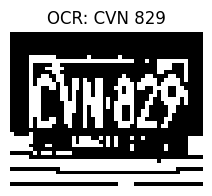

In [69]:
# 2)  Elegir la fila que quieres inspeccionar (0 = primera)
row = df_tx[df_tx["num_auto"] == 80].iloc[0]

# 3)  Recuperar la lista de bits ------------------------------------
# --- Caso A: la columna se llama "bits" y contiene una lista de Python
if "bits" in row:
    bits_cell = row["bits"]

    # Si el CSV guardó la lista como cadena, convérsala a lista real
    if isinstance(bits_cell, str):
        bits = np.array(literal_eval(bits_cell), dtype=np.uint8)
    else:  # ya es list o ndarray
        bits = np.array(bits_cell, dtype=np.uint8)

# --- Caso B: no guardaste los bits en el CSV, sino en archivos .npy
#     (en tu dataset anterior). Entonces la columna sería algo como "bits_path".
elif "bits_path" in row:
    import numpy as np
    bits = np.load(row["bits_path"]).astype(np.uint8)
else:
    raise KeyError("No encuentro columna 'bits' ni 'bits_path' en el CSV.")

print("Longitud vector bits:", bits.size)   # debería ser 2000

# 4)  Reconstruir la placa 50×40 y mostrar
img_bw = (bits.reshape(40, 50) * 255).astype(np.uint8)

plt.figure(figsize=(3, 2))
plt.imshow(img_bw, cmap="gray")
plt.title(f"OCR: {row['ocr_txt']}")
plt.axis("off")
plt.show()

# Set Datos RX

In [76]:
# Cargamos dataset de placas rx

import pandas as pd
# Cargamos el dataset de placas
csv_path = "simulacion/dataset_rx_yolo/dataset_rx.csv"

df_rx = pd.read_csv(csv_path)
df_rx.head()  # Muestra las primeras filas del DataFrame

,num_auto,bw_plate,bits
0,1,dataset_rx_yolo/autos_bw/auto001_rep01.png,"[0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,2,dataset_rx_yolo/autos_bw/auto002_rep01.png,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,dataset_rx_yolo/autos_bw/auto002_rep02.png,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3,dataset_rx_yolo/autos_bw/auto003_rep01.png,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,3,dataset_rx_yolo/autos_bw/auto003_rep02.png,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


Longitud vector bits: 2000


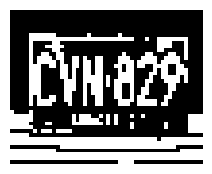

In [ ]:
# 2)  Elegir la fila que quieres inspeccionar (0 = primera)
row = df_rx[df_rx["num_auto"] == 80].iloc[0]

# 3)  Recuperar la lista de bits ------------------------------------
# --- Caso A: la columna se llama "bits" y contiene una lista de Python
if "bits" in row:
    bits_cell = row["bits"]

    # Si el CSV guardó la lista como cadena, convérsala a lista real
    if isinstance(bits_cell, str):
        bits = np.array(literal_eval(bits_cell), dtype=np.uint8)
    else:  # ya es list o ndarray
        bits = np.array(bits_cell, dtype=np.uint8)

# --- Caso B: no guardaste los bits en el CSV, sino en archivos .npy
#     (en tu dataset anterior). Entonces la columna sería algo como "bits_path".
elif "bits_path" in row:
    import numpy as np
    bits = np.load(row["bits_path"]).astype(np.uint8)
else:
    raise KeyError("No encuentro columna 'bits' ni 'bits_path' en el CSV.")

print("Longitud vector bits:", bits.size)   # debería ser 2000

# 4)  Reconstruir la placa 50×40 y mostrar
img_bw = (bits.reshape(40, 50) * 255).astype(np.uint8)

plt.figure(figsize=(3, 2))
plt.imshow(img_bw, cmap="gray")
plt.axis("off")
plt.show()

# Set resultados

In [82]:
import pandas as pd, numpy as np, ast

# ----------------------------------------------------- #
# 1. bits → ndarray                                     #
# ----------------------------------------------------- #
def to_array(x):
    if isinstance(x, (list, np.ndarray)):
        return np.asarray(x, dtype=np.uint8)
    return np.asarray(ast.literal_eval(x), dtype=np.uint8)

df_tx["bits"] = df_tx["bits"].apply(to_array)
df_rx["bits"] = df_rx["bits"].apply(to_array)

# ----------------------------------------------------- #
# 2. renombrar columnas                                 #
# ----------------------------------------------------- #
df_tx_ren = (
    df_tx
      .drop_duplicates("num_auto")        # 1 fila por auto en TX
      .rename(columns={
          "bw_plate": "bw_plate_tx",
          "bits":     "bits_tx",
          "ocr_txt":  "ocr_txt_tx"
      })
)

df_rx_ren = df_rx.rename(columns={
    "bw_plate": "bw_plate_rx",
    "bits":     "bits_rx"
})

# ----------------------------------------------------- #
# 3. merge: muchas RX ↔ única TX                        #
# ----------------------------------------------------- #
df_results = df_rx_ren.merge(
    df_tx_ren,              # referencia
    on="num_auto",
    how="left"              # algún RX sin TX → NaN en columnas _tx
)

# ----------------------------------------------------- #
# 4. métricas                                           #
# ----------------------------------------------------- #
def compare(row):
    a = row["bits_rx"]
    b = row["bits_tx"]
    if not isinstance(b, np.ndarray):
        return pd.Series([False, len(a)])   # sin referencia
    diff = np.sum(a != b) if a.shape == b.shape else max(len(a), len(b))
    return pd.Series([diff == 0, diff])

df_results[["bits_equal", "bit_errors"]] = df_results.apply(compare, axis=1)

# orden opcional
df_results = df_results[[
    "num_auto", "bw_plate_tx", "bw_plate_rx",
    "ocr_txt_tx", "bits_equal", "bit_errors",
    "bits_tx", "bits_rx"
]]

df_results

,num_auto,bw_plate_tx,bw_plate_rx,ocr_txt_tx,bits_equal,bit_errors,bits_tx,bits_rx
0,1,dataset_yolo/autos_bw/auto001.png,dataset_rx_yolo/autos_bw/auto001_rep01.png,KOZ.808,True,0,"[0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,2,dataset_yolo/autos_bw/auto002.png,dataset_rx_yolo/autos_bw/auto002_rep01.png,MAU.096,True,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,dataset_yolo/autos_bw/auto002.png,dataset_rx_yolo/autos_bw/auto002_rep02.png,MAU.096,True,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3,dataset_yolo/autos_bw/auto003.png,dataset_rx_yolo/autos_bw/auto003_rep01.png,URO 387,True,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,3,dataset_yolo/autos_bw/auto003.png,dataset_rx_yolo/autos_bw/auto003_rep02.png,URO 387,True,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...
355,179,dataset_yolo/autos_bw/auto179.png,dataset_rx_yolo/autos_bw/auto179_rep02.png,GcV:208,True,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
356,180,dataset_yolo/autos_bw/auto180.png,dataset_rx_yolo/autos_bw/auto180_rep01.png,IGPz 709,True,0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ..."
357,180,dataset_yolo/autos_bw/auto180.png,dataset_rx_yolo/autos_bw/auto180_rep02.png,IGPz 709,True,0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ..."
358,181,dataset_yolo/autos_bw/auto181.png,dataset_rx_yolo/autos_bw/auto181_rep01.png,IGLT 182/,True,0,"[1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [85]:
# Vemos cuantos son exactamente iguales a los transmitidos y un describe de bit errors

print("{} de {} imagenes se recibieron sin cambios".format(sum(df_results['bits_equal']), len(df_results)))

359 de 360 imagenes se recibieron sin cambios


In [87]:
print("Imagenes recibidas distintas")
df_results[df_results['bits_equal'] == 0]

Imagenes recibidas distintas


,num_auto,bw_plate_tx,bw_plate_rx,ocr_txt_tx,bits_equal,bit_errors,bits_tx,bits_rx
165,212,NaN,dataset_rx_yolo/autos_bw/auto212_rep01.png,NaN,False,2000,NaN,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, ..."


In [88]:
df_results['bit_errors'].describe()

count     360.000000
mean        5.555556
std       105.409255
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      2000.000000
Name: bit_errors, dtype: float64